In [1]:
import logging
import numpy as np
import pandas as pd
from arch import arch_model
from random import gauss
from random import seed
from matplotlib import pyplot as plt
import scipy.stats as sts
import json
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [2]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel

In [3]:
with open('config.json') as file:
    config = json.load(file)

In [4]:
files_folder = config['files_folders']['processed']

# Reading files

In [5]:
rtsi = pd.read_pickle(f'{files_folder}/rtsi.pkl')

In [6]:
rtsi

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,return,log return
<DATE>,,,,,,,
2001-02-18,180.10,180.10,180.10,180.10,0,0.000000,0.000000
2001-02-19,180.10,181.21,176.67,177.29,0,-0.015602,-0.015725
2001-02-20,177.29,179.90,175.28,176.45,0,-0.004738,-0.004749
2001-02-21,176.45,176.45,161.12,162.39,0,-0.079683,-0.083037
2001-02-22,162.39,168.35,162.39,168.31,0,0.036455,0.035807
...,...,...,...,...,...,...,...
2021-10-11,1871.73,1883.71,1867.58,1882.43,1769145502,0.011537,0.011471
2021-10-12,1867.15,1876.79,1860.64,1869.94,1386130631,-0.006635,-0.006657
2021-10-13,1869.05,1869.05,1835.80,1855.11,1830447018,-0.007931,-0.007962


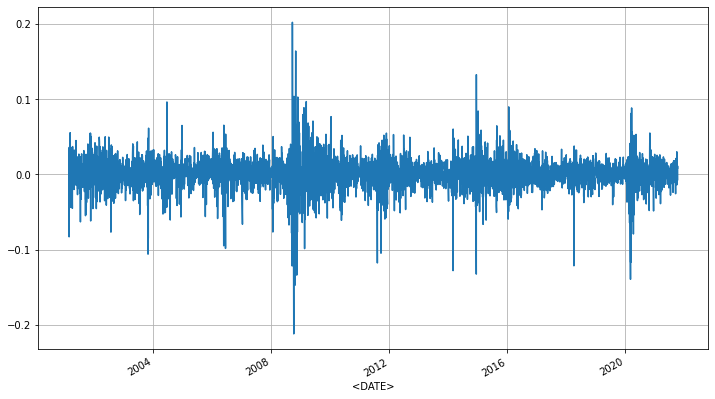

In [7]:
rtsi['log return'].plot(figsize=(12, 7))

plt.grid()
plt.show()

In [8]:
rtsi['log return'].describe()

count    5174.000000
mean        0.000455
std         0.020327
min        -0.211994
25%        -0.008822
50%         0.001318
75%         0.010414
max         0.202039
Name: log return, dtype: float64

# Setting data & parameters

In [9]:
rescale_factor = 100

In [10]:
start_date = '2010-01-01'

In [11]:
input_data = rtsi['log return'].loc[start_date:].copy() * rescale_factor
clusterization_method = 'gaussian'
local_method = 'garch'
local_method_parameters = {'p': 1, 'q': 1, 'mean': 'Zero', 'dist': 'normal'}

In [12]:
n = input_data.shape[0]

In [13]:
n

2965

In [14]:
mu = 0
sigma = .02 * rescale_factor

centers = [mu]  # np.array([[mu] * n])
variances = [sigma ** 2]  # np.array([np.diag([sigma] * n, k=0)])

In [15]:
clusterization_parameters = {'centers': centers, 'variances': variances, 'n_clusters': 1}

## train & test split 

In [16]:
n_train = 2000
n_test = n - n_train

In [17]:
train, test = input_data.iloc[:n_train].copy(), input_data.iloc[n_train:].copy()

In [18]:
# centers_train = centers[:, :n_train].copy()
# cov_matrices_train = cov_matrices[:, :n_train, :n_train].copy()

In [19]:
# clusterization_parameters_train = {'centers': centers_train, 'cov_matrices': cov_matrices_train, 'n_clusters': 1}

## Same data fed to GARCH(1, 1)

In [20]:
model = arch_model(input_data,
                   mean=local_method_parameters['mean'],
                   vol='GARCH', p=local_method_parameters['p'],
                   q=local_method_parameters['q'],
                   dist=local_method_parameters['dist'])

In [21]:
model.volatility

GARCH(p: 1, q: 1), id: 0x7fdaf993ac10

In [22]:
fitted = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18208.402879687113
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179841745.16303405
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6259.643369009693
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5746.523881004245
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5518.704480234793
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5518.7020679092275
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5518.701967731444
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5518.7019340838815
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5518.701934085554
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5518.7019340838815
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


In [23]:
fitted.summary

<bound method ARCHModelResult.summary of                        Zero Mean - GARCH Model Results                        
Dep. Variable:             log return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5518.70
Distribution:                  Normal   AIC:                           11043.4
Method:            Maximum Likelihood   BIC:                           11061.4
                                        No. Observations:                 2965
Date:                Thu, Nov 04 2021   Df Residuals:                     2965
Time:                        20:08:22   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.

In [24]:
fitted.params

omega       0.059160
alpha[1]    0.081849
beta[1]     0.900093
Name: params, dtype: float64

In [25]:
forecast = fitted.forecast(reindex=False, horizon=1)

In [26]:
forecast_variance = forecast.variance.iloc[0]

In [27]:
fitted.forecast(reindex=False, horizon=2).variance

,h.1,h.2
<DATE>,,
2021-10-15,1.817119,1.843465


In [28]:
forecast_variance

h.1    1.817119
Name: 2021-10-15 00:00:00, dtype: float64

# Testing `FuzzyVolatilityModel` class

In [29]:
logging.basicConfig(level=logging.DEBUG)

In [30]:
fvm = FuzzyVolatilityModel(train,
                           clusterization_method=clusterization_method,
                           clusterization_parameters=clusterization_parameters,
                           local_method=local_method,
                           local_method_parameters=local_method_parameters)

INFO:model.FuzzyVolatilityModel:Creating an instance of FuzzyVolatilityModel


## `fit`

In [31]:
fvm.fit()

DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -4043.5895454901565, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4043.5895454901565, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.78705625e-1757]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed


Iteration:      1,   Func. Count:      5,   Neg. LLF: 11932.727543850217
Iteration:      2,   Func. Count:     14,   Neg. LLF: 24066663.767517917
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3815.9104011498903
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5215.352095508891
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3957.8020446173223
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3807.8476247138947
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3807.730001725556
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3807.729043605945
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3807.7290429766836
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3807.7290429766836
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


In [32]:
fvm.forecast()

DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1640601558440875]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1640601558440875


In [33]:
fvm.current_output

1.1640601558440875074

In [34]:
fvm.membership_degrees_current

array([7.78705625e-1757], dtype=float128)

In [35]:
fvm.clusters_parameters_current

{'centers': [0], 'variances': [4.0], 'n_clusters': 1}

## `forecast`

In [36]:
# fvm.forecast()

In [37]:
fvm.current_output

1.1640601558440875074

## `feed_daily_data`

In [38]:
test_small = test.iloc[:11].copy()

In [39]:
%%time

fvm.feed_daily_data(test_small)

DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -4045.276063319716, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4045.276063319716, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.44187604e-1757]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1538362626947958]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11938.79698400292
Iteration:      2,   Func. Count:     14,   Neg. LLF: 24687153.870436523
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3817.437383590056
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5179.656696955189
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4005.499174151879
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3809.18055778908
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3808.981025987488
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3808.979574857023
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3808.9795734129384
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3808.979573411462
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3808.9795734129384
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4046.953476478486, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4046.953476478486, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.69424227e-1758]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1384422878702163]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1384422878702163
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11944.836856202703
Iteration:      2,   Func. Count:     13,   Neg. LLF: 189936494.689183
Iteration:      3,   Func. Count:     18,   Neg. LLF: 16743.820486595738
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3819.893392109486
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5016.136776077809
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3815.7387946106073
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3810.197153033996
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3810.196363608463
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3810.1963595954794
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3810.1963595959137
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3810.1963595954794
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4048.5665746737104, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4048.5665746737104, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.36879722e-1759]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0814454072547575]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0814454072547575
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11950.808593684204
Iteration:      2,   Func. Count:     13,   Neg. LLF: 185662381.9794952
Iteration:      3,   Func. Count:     18,   Neg. LLF: 5062.362953575363
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3818.733941140039
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4994.856624000879
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3815.8339851653404
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3811.183327058603
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3811.1830834606803
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3811.1830820013865
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3811.1830820023006
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3811.1830820013865
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4050.193486246897, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4050.193486246897, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.05515991e-1759]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0385237315903229]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0385237315903229
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11956.785595225587
Iteration:      2,   Func. Count:     13,   Neg. LLF: 182080982.46528172
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4193.328173081277
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3817.1321183002883
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4041.967167662161
Iteration:      6,   Func. Count:     33,   Neg. LLF: 3818.049139557475
Iteration:      7,   Func. Count:     38,   Neg. LLF: 3812.200079016845
Iteration:      8,   Func. Count:     42,   Neg. LLF: 3812.19545158859
Iteration:      9,   Func. Count:     46,   Neg. LLF: 3812.1954450246467
Iteration:     10,   Func. Count:     49,   Neg. LLF: 3812.1954450253543
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3812.1954450246467
            Iterations: 10
            Function evaluations: 49
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4051.8081776312056, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4051.8081776312056, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.09926239e-1760]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9910406428359273]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9910406428359273
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11962.759802448603
Iteration:      2,   Func. Count:     13,   Neg. LLF: 177133982.30101582
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3944.5815957434006
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3817.326059273135
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4926.084971875299
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3814.3514546862298
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3813.142596852469
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3813.1425840190054
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3813.142583489662
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3813.142583489662
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4053.4342124596055, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4053.4342124596055, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.12941728e-1761]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9550950391382107]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9550950391382107
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11968.74307007086
Iteration:      2,   Func. Count:     13,   Neg. LLF: 175378893.4091766
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3877.520164888751
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3817.641447901574
Iteration:      5,   Func. Count:     28,   Neg. LLF: 6534.119552744245
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3814.303711815931
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3814.118675961201
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3814.1126197107915
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3814.1126197109866
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3814.1126197107915
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4055.7964628572377, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4055.7964628572377, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.89024057e-1762]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.418776400525191]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.418776400525191
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11975.624993687112
Iteration:      2,   Func. Count:     14,   Neg. LLF: 25411590.59644759
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3825.486768218312
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5423.551814097434
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3866.630426066304
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3818.1283809168667
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3818.123499087722
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3818.123488119668
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3818.1234881197724
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3818.123488119668
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4058.2507178271358, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4058.2507178271358, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.3427744e-1763]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8929836680543304]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8929836680543304
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11982.619293829863
Iteration:      2,   Func. Count:     14,   Neg. LLF: 17231660.698059242
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3827.1127290965715
Iteration:      4,   Func. Count:     24,   Neg. LLF: 6315.26828918682
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3821.8600774106726
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3821.681175779466
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3821.584794975642
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3821.5847909015783
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3821.5847909012764
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3821.5847909015783
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4059.8904157467186, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4059.8904157467186, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.48627428e-1764]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7813052675421783]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7813052675421783
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering metho

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11988.61938299462
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18056057.088690937
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3828.7611319038497
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5997.988875962443
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3825.2521500471544
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3822.9555755598076
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3822.8807881002317
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3822.8807088666395
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3822.880708865908
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3822.8807088666395
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4061.57398472208, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4061.57398472208, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.20456598e-1764]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7101075612149081]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7101075612149081
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11994.673093063426
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18647442.261568148
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3830.407373641846
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5822.84881674375
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3834.106648727806
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3824.2826109564785
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3824.248765654793
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3824.248621010631
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3824.2486210099933
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3824.248621010631
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4063.210896550367, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4063.210896550367, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.34384463e-1765]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6155671063861177]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6155671063861177


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12000.6698613
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19571755.16894725
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3832.017630158406
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5653.163363511379
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3840.8737246174264
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3825.5026329069024
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3825.493854129598
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3825.4936044109427
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3825.493583958752
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3825.49358395958
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3825.493583958752
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
CPU times: user 24.6 s, sys: 1.4 s, total: 26 s
Wall time: 14.8 s


In [40]:
len(fvm._hist_output)

12

In [41]:
test_small.shape

(11,)

In [42]:
fvm._hist_output

[1.1640601558440875074,
 1.1538362626947957779,
 1.1384422878702162851,
 1.0814454072547574626,
 1.0385237315903228517,
 0.991040642835927299,
 0.9550950391382106997,
 1.4187764005251910504,
 1.8929836680543303818,
 1.7813052675421783277,
 1.7101075612149081451,
 1.6155671063861176684]

In [43]:
fvm._rules_outputs_hist

[[1.1640601558440875],
 [1.1538362626947958],
 [1.1384422878702163],
 [1.0814454072547575],
 [1.0385237315903229],
 [0.9910406428359273],
 [0.9550950391382107],
 [1.418776400525191],
 [1.8929836680543304],
 [1.7813052675421783],
 [1.7101075612149081],
 [1.6155671063861177]]

In [44]:
np.array(fvm._rules_outputs_hist)[:, 0].round(4) == np.array(fvm._hist_output).round(4)

array([False, False, False, False, False, False, False, False, False,
       False, False, False])

In [45]:
np.array(fvm._rules_outputs_hist, dtype=np.float128)[:, 0].round(4)

array([1.1641, 1.1538, 1.1384, 1.0814, 1.0385, 0.991 , 0.9551, 1.4188,
       1.893 , 1.7813, 1.7101, 1.6156], dtype=float128)

In [46]:
np.array(fvm._hist_output, dtype=np.float128).round(4)

array([1.1641, 1.1538, 1.1384, 1.0814, 1.0385, 0.991 , 0.9551, 1.4188,
       1.893 , 1.7813, 1.7101, 1.6156], dtype=float128)

In [47]:
(_ == __).all()

True

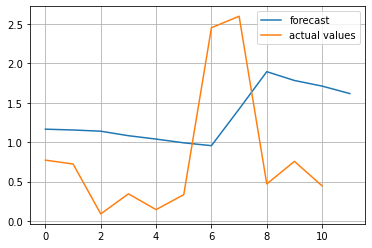

In [50]:
plt.plot(fvm._hist_output, label='forecast')
plt.plot(test_small.values, label='actual values')

plt.legend()
plt.grid()
plt.show()

In [90]:
test_small.index

DatetimeIndex(['2017-12-22', '2017-12-25', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-09', '2018-01-10'],
              dtype='datetime64[ns]', name='<DATE>', freq=None)

In [92]:
fvm.hist_output.index

DatetimeIndex(['2017-12-22', '2017-12-25', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-09', '2018-01-10'],
              dtype='datetime64[ns]', freq=None)

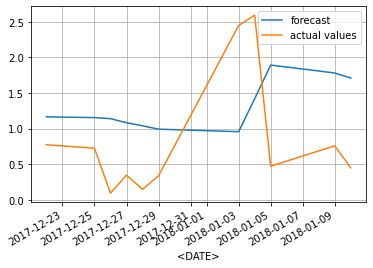

In [101]:
fvm.hist_output.plot(label='forecast')
test_small.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

In [105]:
mean_squared_error(fvm.hist_output, test_small, squared=True)

1.0460753597481783189

In [106]:
mean_squared_error(fvm.hist_output, test_small, squared=False)

1.0227782554142311833

In [107]:
mean_absolute_percentage_error(fvm.hist_output, test_small)

0.75436019368052235223